In [65]:
import numpy as np
import matplotlib.pyplot as plt

# IsolationForest 

In [132]:
d = np.array([[1,1,2],[3,2,4],[2,1,2],[3,1,2],[7,8,9],[2,1,2],[11,1,11]])

In [137]:
# 随机切分数据
def split_data(data, col)->"根据随机选择的col选择在最大最小值之间随机选一个值划分数据集":
    """
    返回两个数据值，及随机划分的阈值
    """
    if isinstance(data, list):
        data = np.array(data)
    elif not isinstance(data, (np.ndarray, np.matrixlib.defmatrix.matrix)):
        raise TypeError("data type must fit the algorithm")
        
    split_col = data[:, col]
    minx = np.min(split_col)
    maxx = np.max(split_col)
    # 得到随机划分的值
    split_value = minx + np.random.rand(1) * (maxx - minx)
    left_data = data[data[:, col] < split_value]
    right_data = data[data[:, col] >= split_value]
    return left_data, right_data, np.round(split_value, 3)


def sample_data(data, ratio):
    """
    随机选择数据集
    """
    if isinstance(data, list):
        m, n = len(data), len(data[0])
    elif isinstance(data, (np.ndarray, np.matrixlib.defmatrix.matrix)):
        m, n = data.shape
    else:
        raise TypeError("wrong")
    
    if 0 < ratio < 1:
        sub_m = int(ratio * m)
    elif isinstance(ratio, int):
        sub_m = max(min(ratio, m), 0.5 * m)
        # 至少取一半的样本 进行分析
    else:
        raise ValueError("wrong")
    
    new_data = []
    random_indx = np.random.permutation(m)[: sub_m]
    for idx in random_indx:
        new_data.append(data[idx])
    return np.array(new_data), sub_m

In [138]:
# build_tree
def itree(data, max_deep, cur_deep=0):
    m, n = data.shape
    # 返回叶子节点 样本的数量
    if m <= 2 or cur_deep > max_deep:
        return m
    col = np.random.randint(n)
    left_data, right_data, split_value = split_data(data, col)
    
    tree_dict = {}
    tree_dict["split_val"] = split_value
    tree_dict["split_col"] = col
    tree_dict["left"] =  itree(left_data, max_deep, cur_deep=cur_deep+1)
    tree_dict["right"] = itree(right_data, max_deep, cur_deep=cur_deep+1)
    return tree_dict

# max_deep = get_max_deep(7)
# tx = itree(d, max_deep)

In [139]:
def get_max_deep(num):
    return np.ceil(np.log2(num))

def cost(num_items):
    if num_items > 2:
    # 二叉搜索树的平均路径长度。0.5772156649:欧拉常数
        re =  2 * ((np.log2(num_items - 1) + 0.5772156649) - (num_items - 1) / num_items)
        return re
    elif num_items == 2:
        return 1
    else:
        return 0
    
def get_length(tree, x): 
    """
    计算样本的 评价深度
    """
    split_value = tree['split_val']
    split_ind = tree['split_col']
    if x[split_ind] > split_value:
        if isinstance(tree['right'], dict):
            mdeep = 1 + get_length(tree['right'], x)
        else:
            mdeep = cost(tree['right']) # 注意这里的平滑系数。
    else: 
        if isinstance(tree['left'], dict):
            mdeep = 1 + get_length(tree['left'], x)
        else:
            mdeep = cost(tree['left']) # 当 2为 当样本数量很少时。
    return mdeep

# get_length(tx, x = [0,0,1])

In [151]:
def isolation_forest(data, ratio, num_trees=10):
    Trees = []
    sub_ms = []
    for i in range(10):
        random_data, sub_m = sample_data(data, ratio)
        max_deep = get_max_deep(sub_m)
        ITree = itree(random_data, max_deep)
        Trees.append(ITree)
        sub_ms.append(sub_m)
    return Trees, sub_ms
    
def predict_score(data, x, ratio=5, num_trees=10):
    predictions = []
    ITrees, sub_ms = isolation_forest(data, ratio, num_trees=num_trees)
    data_num = np.mean(sub_ms)
    for itree in ITrees:
        predict = get_length(itree, x)
        predictions.append(predict)
    return np.power(2, -np.sum(predictions) /len(predictions) / cost(data_num))  


# trees, sub_ms = isolation_forest(d, ratio=5)
predict_score(d, [110,1110,1011], ratio=5)

0.9617489194779455

In [130]:
# 计算 树 叶子的数量
def treeleaf_count(mytree):
    num_feature = 0
    for key in ["left", "right"]:
        if isinstance(mytree[key], dict):
            num_feature += tree_leafs(mytree[key])
        else:
            num_feature += mytree[key]
    return num_feature

# np.max([1, 3]) 与 max 的区别 需要注意
# 计算树的 最大深度
def tree_deep(mytree):
    max_deep = 0
    for key in ["left", "right"]:
        if isinstance(mytree[key] ,dict):
            temp_deep = tree_deep(mytree[key]) + 1
        else:
            temp_deep = 1   
        max_deep = max(max_deep, temp_deep)
    return max_deep

treeleaf_count(tx)
tree_deep(tx)

4

# IsolationForest sklearn test

In [2]:
from sklearn.ensemble import IsolationForest

/Users/luokui/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
rng = np.random.RandomState(42)

In [98]:
x = 0.3 * rng.randn(100, 2)
x_train = np.r_[x+2,x-2] # shape 为 200*2
x = 0.3 * rng.randn(20,2)
x_test = np.r_[x+2,x-2]
x_outliers = rng.uniform(low=4,high=8,size=(20,2))

In [99]:
clf  = IsolationForest(max_samples=100,random_state=rng)
clf.fit(x_train)
y_pred_train = clf.predict(x_train)
y_pred_test = clf.predict(x_test)
y_pred_out = clf.predict(x_outliers)

/Users/luokui/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [106]:
print(y_pred_test)
scores = clf.decision_function(x_test)
scores

[ 1  1  1  1  1 -1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1 -1
 -1 -1  1  1  1  1  1 -1  1 -1  1  1  1  1  1 -1]


array([ 0.04296877,  0.02678717,  0.05941828, -0.02894252, -0.02450608,
       -0.06188335,  0.0317513 , -0.00581646,  0.04754161,  0.01508426,
        0.03723326, -0.02575034,  0.07259981, -0.06574383, -0.00770386,
        0.07266559,  0.04148288,  0.0247486 ,  0.06159988, -0.02789956,
        0.04942211,  0.03165125,  0.06799023, -0.03626232, -0.05520428,
       -0.06336819,  0.04819278,  0.01270013,  0.05562842,  0.01658977,
        0.04957799, -0.03951447,  0.07246228, -0.06708094, -0.02131181,
        0.07088907,  0.02565735,  0.05116798,  0.06482492, -0.05311576])

In [110]:
from sklearn.preprocessing import binarize
print(binarize([scores]))
#print(y_pred_test)
#np.sign(scores)

[[1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0.
  0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0.]]


In [25]:
xx,yy = np.meshgrid(np.linspace(-5,5,50),np.linspace(-5,5,50))
z = clf.decision_function(np.c_[xx.ravel(),yy.ravel()])
z = z.reshape(xx.shape)

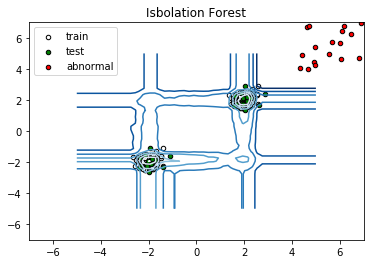

In [26]:
plt.title("Isbolation Forest")
plt.contour(xx,yy,z,cmap = plt.cm.Blues_r)

b1 = plt.scatter(x_train[:,0],x_train[:,1],c='white',s=20,edgecolor='k')
b2 = plt.scatter(x_test[:,0],x_test[:,1],c='green',s=20,edgecolor='k')
c = plt.scatter(x_outliers[:,0],x_outliers[:,1],c='red',s=20,edgecolor='k')
plt.axis('tight')
plt.xlim((-7,7))
plt.ylim((-7,7))
plt.legend([b1,b2,c],['train','test','abnormal'],loc='upper left')
plt.show()


# LOF

In [27]:
from sklearn.neighbors import  LocalOutlierFactor

/Users/luokui/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


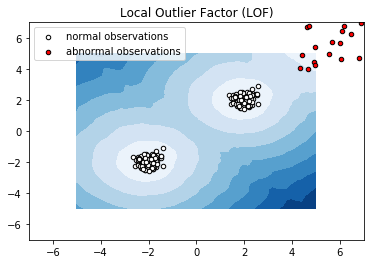

In [91]:
model_2 = LocalOutlierFactor(n_neighbors=20)
new_x =  np.concatenate([x_train,x_outliers],axis=0)
y_pred = model_2.fit_predict(new_x)
y_pred_out = y_pred[200:]

xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = model_2._decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Local Outlier Factor (LOF)")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

a = plt.scatter(new_x[:200, 0], new_x[:200, 1], c='white',
                edgecolor='k', s=20)
b = plt.scatter(new_x[200:, 0], new_x[200:, 1], c='red',
                edgecolor='k', s=20)
plt.axis('tight')
plt.xlim((-7, 7))
plt.ylim((-7, 7))
plt.legend([a, b],["normal observations","abnormal observations"],
           loc="upper left")
plt.show()

In [97]:
#y_pred

In [96]:
#model_2.negative_outlier_factor_

/Users/luokui/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


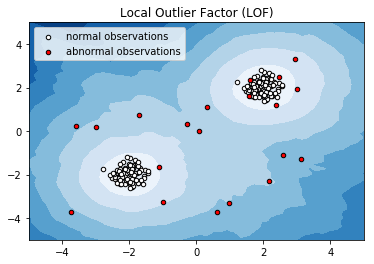

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

np.random.seed(42)

# Generate train data
X = 0.3 * np.random.randn(100, 2)
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X = np.r_[X + 2, X - 2, X_outliers]

# fit the model
clf = LocalOutlierFactor(n_neighbors=20)
y_pred = clf.fit_predict(X)
y_pred_outliers = y_pred[200:]

# plot the level sets of the decision function
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Local Outlier Factor (LOF)")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

a = plt.scatter(X[:200, 0], X[:200, 1], c='white',
                edgecolor='k', s=20)
b = plt.scatter(X[200:, 0], X[200:, 1], c='red',
                edgecolor='k', s=20)
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a, b],
           ["normal observations",
            "abnormal observations"],
           loc="upper left")
plt.show()

In [61]:
a,b = model_2.kneighbors([[1,1]])
b
# a为距离，b为index 用来找到指点点 到哪20（参数）点的距离最近

array([[50, 35, 91, 38, 51, 61, 53, 45, 74, 80, 21, 14, 43, 99, 79, 18,
        52, 28, 48, 34]])

In [63]:
samples = [[0., 0., 0.], [0., .5, 0.], [1., 1., .5]]
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=1,n_jobs=-1)
neigh.fit(samples) 
#NearestNeighbors(algorithm='auto', leaf_size=30, ...)
print(neigh.kneighbors([[0,0.1,0]])) 

(array([[0.1]]), array([[0]]))


In [68]:
neigh.kneighbors_graph([[0,0,2]])#.toarray()

<1x3 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

# oneclassSVM

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))

X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

In [70]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

In [74]:
n_error_train
n_error_test
n_error_outliers

0

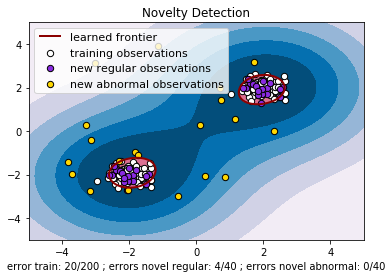

In [71]:
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s, edgecolors='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s,edgecolors='k')

plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"% (n_error_train, n_error_test, n_error_outliers))
plt.show()

In [75]:
# outier detection

In [76]:
import numpy as np
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn.datasets import load_boston

# Get data
X1 = load_boston()['data'][:, [8, 10]]  # two clusters
X2 = load_boston()['data'][:, [5, 12]]

In [80]:
X1.shape
X2.shape

(506, 2)

In [83]:
load_boston().keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR'])

In [88]:
classifiers = {
    "Empirical Covariance": EllipticEnvelope(support_fraction=1.,
                                             contamination=0.261),
    "Robust Covariance (Minimum Covariance Determinant)":
    EllipticEnvelope(contamination=0.261),
    "OCSVM": OneClassSVM(nu=0.261, gamma=0.05)}
colors = ['m', 'g', 'b']
legend1 = {}
legend2 = {}

# Learn a frontier for outlier detection with several classifiers
xx1, yy1 = np.meshgrid(np.linspace(-8, 28, 500), np.linspace(3, 40, 500))
xx2, yy2 = np.meshgrid(np.linspace(3, 10, 500), np.linspace(-5, 45, 500))
for i, (clf_name, clf) in enumerate(classifiers.items()):
    plt.figure(1)
    clf.fit(X1)
    Z1 = clf.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
    Z1 = Z1.reshape(xx1.shape)
    legend1[clf_name] = plt.contour(
        xx1, yy1, Z1, levels=[0], linewidths=2, colors=colors[i])
    plt.figure(2)
    clf.fit(X2)
    Z2 = clf.decision_function(np.c_[xx2.ravel(), yy2.ravel()])
    Z2 = Z2.reshape(xx2.shape)
    legend2[clf_name] = plt.contour(
        xx2, yy2, Z2, levels=[0], linewidths=2, colors=colors[i])

legend1_values_list = list(legend1.values())
legend1_keys_list = list(legend1.keys())

/Users/luokui/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


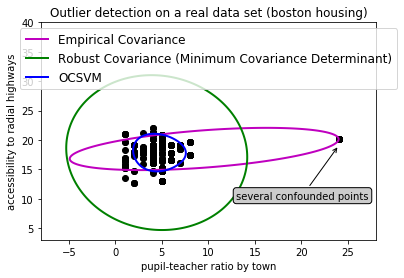

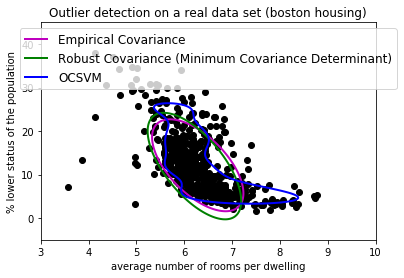

In [89]:
# Plot the results (= shape of the data points cloud)
plt.figure(1)  # two clusters
plt.title("Outlier detection on a real data set (boston housing)")
plt.scatter(X1[:, 0], X1[:, 1], color='black')
bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")
plt.annotate("several confounded points", xy=(24, 19),
             xycoords="data", textcoords="data",
             xytext=(13, 10), bbox=bbox_args, arrowprops=arrow_args)
plt.xlim((xx1.min(), xx1.max()))
plt.ylim((yy1.min(), yy1.max()))
plt.legend((legend1_values_list[0].collections[0],
            legend1_values_list[1].collections[0],
            legend1_values_list[2].collections[0]),
           (legend1_keys_list[0], legend1_keys_list[1], legend1_keys_list[2]),
           loc="upper center",
           prop=matplotlib.font_manager.FontProperties(size=12))
plt.ylabel("accessibility to radial highways")
plt.xlabel("pupil-teacher ratio by town")

legend2_values_list = list(legend2.values())
legend2_keys_list = list(legend2.keys())

plt.figure(2)  # "banana" shape
plt.title("Outlier detection on a real data set (boston housing)")
plt.scatter(X2[:, 0], X2[:, 1], color='black')
plt.xlim((xx2.min(), xx2.max()))
plt.ylim((yy2.min(), yy2.max()))
plt.legend((legend2_values_list[0].collections[0],
            legend2_values_list[1].collections[0],
            legend2_values_list[2].collections[0]),
           (legend2_keys_list[0], legend2_keys_list[1], legend2_keys_list[2]),
           loc="upper center",
           prop=matplotlib.font_manager.FontProperties(size=12))
plt.ylabel("% lower status of the population")
plt.xlabel("average number of rooms per dwelling")

plt.show()

In [90]:
#ourlier detectuon with several method